<a href="https://colab.research.google.com/github/Suprim-Shakya/Learning_PyTorch/blob/main/01_PyTorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Workflow


# Contents
1: "data (prepare and load)",

2: "build model",

3: "fitting the model to data (training)",

4: "making predictions and evaluating a model (inference)",

5: "saving and loading a model",

6: "putting it all together"

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

## 1. Preparing and loading

In [2]:
# Using linear regression formula y=a+mx
# Create known parameters
w = 0.7
b = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = w * X + b
X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting our data into training and test sets

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
# Plotting of the data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))

  plt.scatter(X_train, y_train, c="b", s=4, label="Training data")
  plt.scatter(X_test, y_test, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})


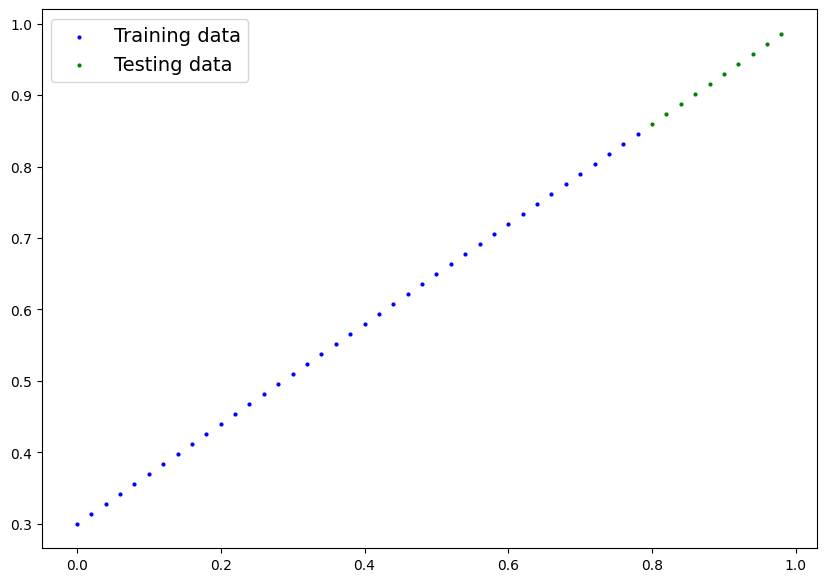

In [6]:
plot_predictions()

## 2. Building a model

In [7]:
# Create a Linear Regression Model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(1,
                                            dtype=float),
                                requires_grad=True) # <- start with random weights
    self.bias = nn.Parameter(torch.randn(1,dtype=float),
                             requires_grad=True)

    # Forward defines the computation in the model
  def forward(self, X : torch.Tensor) -> torch.Tensor:
    return self.weights * X + self.bias


## Checking contents of a PyTorch model

In [8]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.1288], dtype=torch.float64, requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

### Making predictions using torch.inference_mode()

In [10]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [11]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)


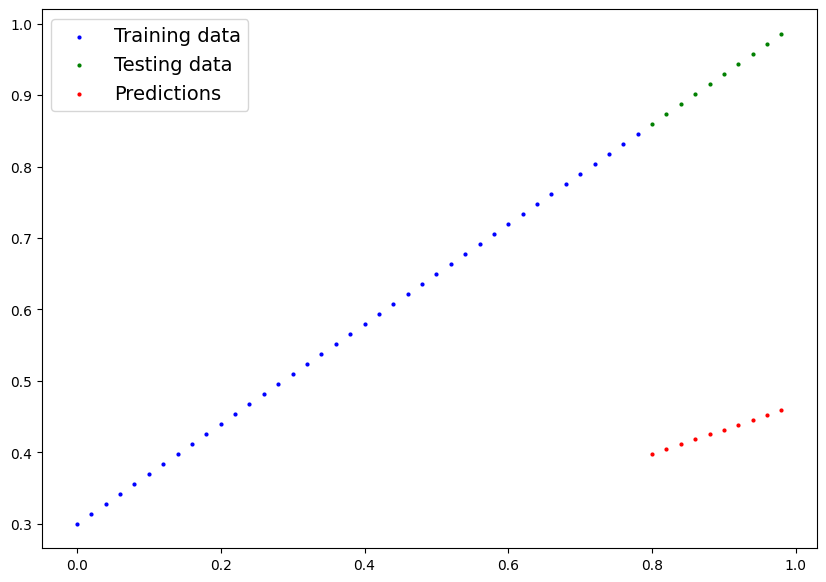

In [12]:
plot_predictions(predictions=y_preds)

### 3. Train model

In [13]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [14]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288135683755547 | MAE Test Loss: 0.4810651841540759 
Epoch: 10 | MAE Train Loss: 0.1976713574739093 | MAE Test Loss: 0.346355184508239 
Epoch: 20 | MAE Train Loss: 0.08908721056311557 | MAE Test Loss: 0.21729648486064157 
Epoch: 30 | MAE Train Loss: 0.05314849742260115 | MAE Test Loss: 0.14464008519991425 
Epoch: 40 | MAE Train Loss: 0.04543793101588776 | MAE Test Loss: 0.11360938544629148 
Epoch: 50 | MAE Train Loss: 0.041678606478126046 | MAE Test Loss: 0.09919938569279392 
Epoch: 60 | MAE Train Loss: 0.03818929484512264 | MAE Test Loss: 0.08886628595826254 
Epoch: 70 | MAE Train Loss: 0.03476085499350197 | MAE Test Loss: 0.08059388621223337 
Epoch: 80 | MAE Train Loss: 0.031323806993240874 | MAE Test Loss: 0.07232148646620422 
Epoch: 90 | MAE Train Loss: 0.02788736528831538 | MAE Test Loss: 0.06473598671634251 
Epoch: 100 | MAE Train Loss: 0.024458925436694718 | MAE Test Loss: 0.056463586970313374 
Epoch: 110 | MAE Train Loss: 0.021020207499473125 | MA

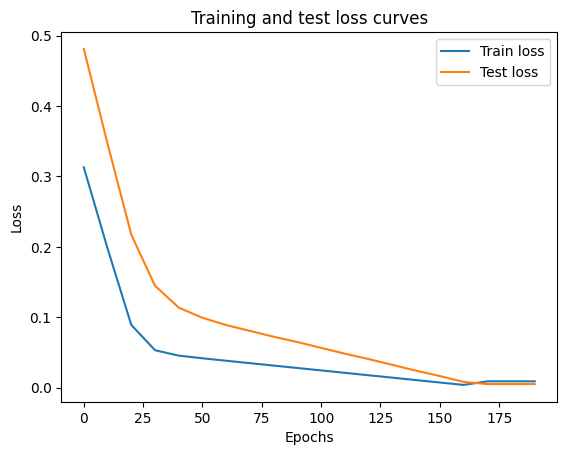

In [15]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [16]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {w}, bias: {b}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990], dtype=torch.float64)), ('bias', tensor([0.3093], dtype=torch.float64))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 4. Making predictions with a trained PyTorch model

In [17]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]], dtype=torch.float64)

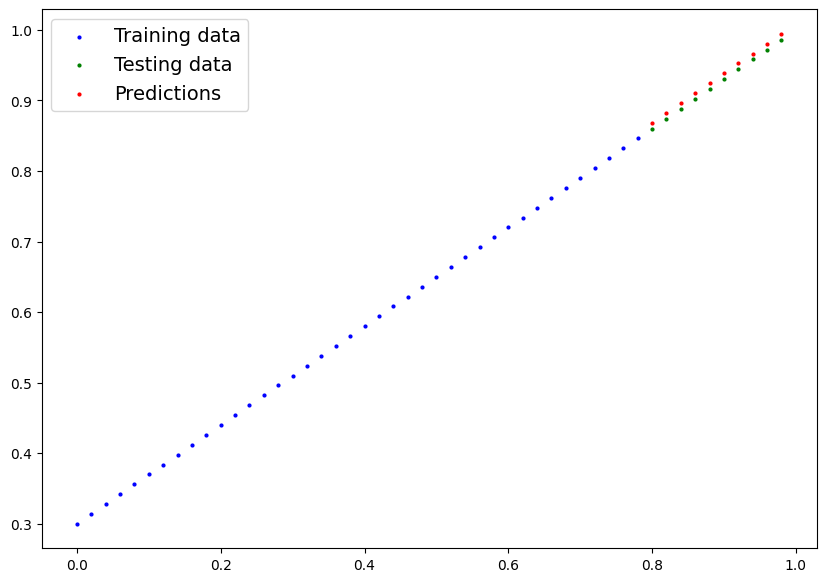

In [18]:
plot_predictions(predictions=y_preds)

In [19]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [20]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [22]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Putting Everything together

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
torch.__version__

'2.3.0+cu121'

In [24]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [25]:
w = 0.4
b = 0.6
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = w * X + b
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.6000],
         [0.6080],
         [0.6160],
         [0.6240],
         [0.6320],
         [0.6400],
         [0.6480],
         [0.6560],
         [0.6640],
         [0.6720]]))

In [26]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

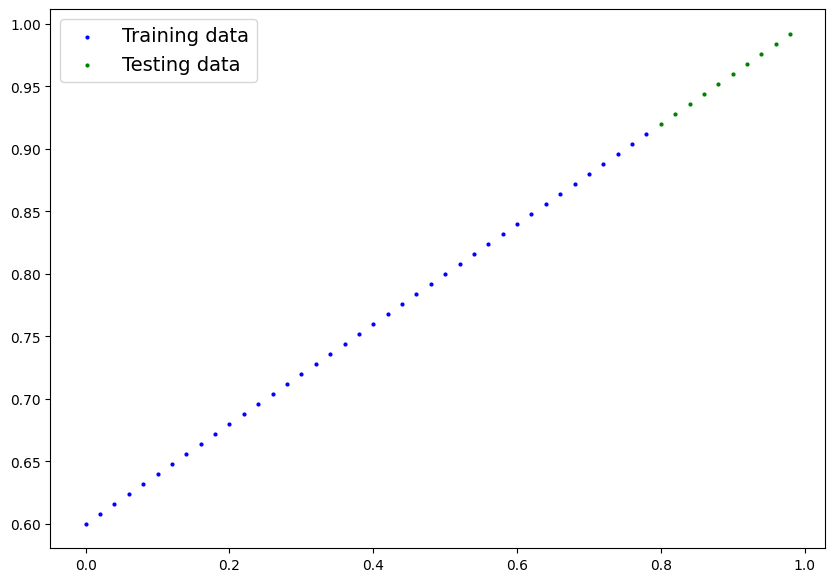

In [27]:
plot_predictions(X_train, y_train, X_test, y_test)

In [28]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, X):
        return self.linear_layer(X)

In [29]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [30]:
next(model_1.parameters()).device

device(type='cpu')

In [31]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [32]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [33]:
torch.manual_seed(42)
epochs = 200
#Put data on the target device i.e. cuda
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
for epoch in range(epochs):
    model_1.train()

    y_pred = model_1(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.37217792868614197 | MAE Test Loss: 0.5409762263298035
Epoch: 10 | MAE Train Loss: 0.25696802139282227 | MAE Test Loss: 0.40626636147499084
Epoch: 20 | MAE Train Loss: 0.14175815880298615 | MAE Test Loss: 0.2715565860271454
Epoch: 30 | MAE Train Loss: 0.06014268472790718 | MAE Test Loss: 0.16236841678619385
Epoch: 40 | MAE Train Loss: 0.04442605376243591 | MAE Test Loss: 0.11533119529485703
Epoch: 50 | MAE Train Loss: 0.039858993142843246 | MAE Test Loss: 0.09621082991361618
Epoch: 60 | MAE Train Loss: 0.036368973553180695 | MAE Test Loss: 0.08519107848405838
Epoch: 70 | MAE Train Loss: 0.03291735798120499 | MAE Test Loss: 0.07623185962438583
Epoch: 80 | MAE Train Loss: 0.029478544369339943 | MAE Test Loss: 0.0679594948887825
Epoch: 90 | MAE Train Loss: 0.026044202968478203 | MAE Test Loss: 0.06037399172782898
Epoch: 100 | MAE Train Loss: 0.02261371724307537 | MAE Test Loss: 0.05210161954164505
Epoch: 110 | MAE Train Loss: 0.01917489431798458 | MAE Test Loss

In [34]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4077]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.6040], device='cuda:0'))])

In [35]:
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds, type(y_preds)

(tensor([[0.9302],
         [0.9383],
         [0.9465],
         [0.9546],
         [0.9628],
         [0.9709],
         [0.9791],
         [0.9872],
         [0.9954],
         [1.0035]], device='cuda:0'),
 torch.Tensor)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

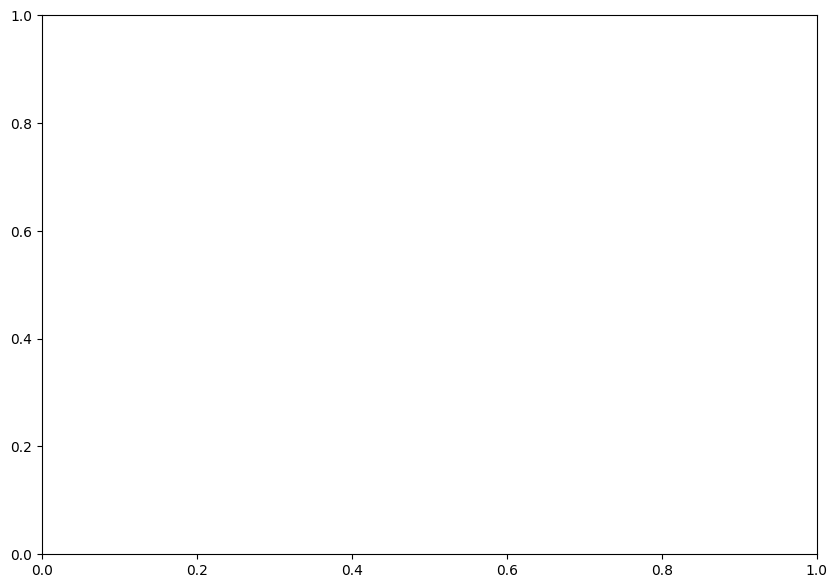

In [36]:
plot_predictions(predictions=y_preds.cpu())